In [1]:
import matplotlib.pyplot as plt
import numpy as np
from functions.CreateYarnGeneral import CreateYarn

In [2]:
!rm -r output/
!mkdir output/
!mkdir output/mesh
!mkdir output/ccx

In [3]:
# cualquier curva periodica puede ser describida por una serie de fourier

r = 5

trajs =[]  

fc1 = lambda x: np.sqrt(r**2 - x**2)

nq = 2
fc1 = lambda x: (r**nq - x**nq)**(1/nq)
x12 = np.linspace(0,r,2000)
y12 = fc1(x12)

trajs.append( np.array([x12,y12, np.zeros_like(x12)]).T )

# =============================================================================

fc1 = lambda x: -np.sqrt(r**2 - (x-2*r)**2) + 2*r
nq = 2
fc1 = lambda x: -(r**nq - (x-2*r)**nq)**(1/nq) + 2*r
x12 = np.linspace(r,2*r,2000)
y12 = fc1(x12)

trajs.append( np.array([x12,y12, np.zeros_like(x12)]).T )


(np.float64(-0.5), np.float64(10.5), np.float64(-0.5), np.float64(10.5))

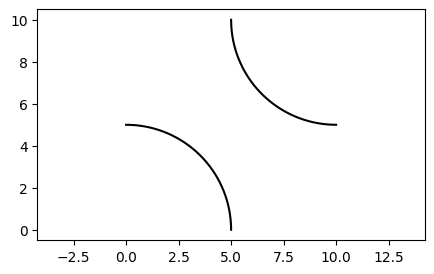

In [4]:

fig = plt.figure()
fig.set_size_inches(5, 3)
# compute fourier coefficients
for itraj in trajs:

    plt.plot(itraj[:,0], itraj[:,1], 'k')

plt.axis('equal')

In [5]:
radius = 1

first_vectors = [ [1, 0, 0] , [0, -1, 0] ]
last_vectors  = [ [0, -1, 0], [1,  0, 0] ]


for i,itraj in enumerate(trajs):

    file = "output/mesh/yarn_" + str(i) + ".brep"

    CreateYarn({"trajs": itraj, 
                "radius": radius, 
                "last_vector": last_vectors[i],
                "first_vector": first_vectors[i],
                "density": 1,
                "file": file})

In [6]:
from functions.CreateCompositeMinRVE import CreateCompositeMinRVE

In [7]:
params_mesh = {
    "files": ["output/mesh/yarn_0.brep", 
              "output/mesh/yarn_1.brep"],
    "inp_file": "output/mesh/sandwich_pbc_min.inp",
    "trajs": trajs,
    "radius": radius,
    "r": r
}

CreateCompositeMinRVE(params_mesh);

In [8]:
from CompositeRVE.Simulation import Simulation

Wine está instalado. Versión: wine-9.0
Wine is installed. Calculix will be run with windows binary


In [9]:
from validation.experimental import carbonfiber,resina

In [10]:
carbon_data = carbonfiber()
resina_data = resina()

In [11]:
resina_data

{'resistencia [kg/cm2]': 650,
 'alargamiento rotura[%]': 0.025,
 'resistencia [MPa]': 63.74322499999999,
 'young modulus [MPa]': 2549.7289999999994,
 'poisson ratio': 0.265}

In [12]:
Ecarbon_MPa = carbon_data["carbon"].iloc[0]["Young Modulus (GPa)"]*1e-3
poisson_carbon = carbon_data["poisson ratio"]

In [13]:
materials = {
    "matrix": { "E" : resina_data["young modulus [MPa]"], 
                "nu": resina_data["poisson ratio"] },
    "carbon": { "E" : Ecarbon_MPa, 
                "nu": poisson_carbon }
}

params_sim = {
    "mesh": params_mesh,
    "output": "output/ccx/",
    "epsilon": 0.125,
    "nsteps":5,
    "materials": materials
}


In [14]:
params_sim["mesh"]["inp_file"]

'output/mesh/sandwich_pbc_min.inp'

In [15]:
frd = Simulation(params_sim)

Running Calculix at:  output/ccx/
Output file:  /home/djoroya/Documents/CITISENS_Composite/scripts/MinRVE/output/ccx/out.txt
Command:
 wine /home/djoroya/Documents/CITISENS_Composite/.conda/lib/python3.13/site-packages/djccx/bin/ccx_dynamic.exe main > out.txt
Error reading cvf file

pid:  61691 

Calculix finished



In [16]:
params_sim

{'mesh': {'files': ['output/mesh/yarn_0.brep', 'output/mesh/yarn_1.brep'],
  'inp_file': 'output/mesh/sandwich_pbc_min.inp',
  'trajs': [array([[0.00000000e+00, 5.00000000e+00, 0.00000000e+00],
          [2.50125063e-03, 4.99999937e+00, 0.00000000e+00],
          [5.00250125e-03, 4.99999750e+00, 0.00000000e+00],
          ...,
          [4.99499750e+00, 2.23606770e-01, 0.00000000e+00],
          [4.99749875e+00, 1.58133646e-01, 0.00000000e+00],
          [5.00000000e+00, 0.00000000e+00, 0.00000000e+00]], shape=(2000, 3)),
   array([[ 5.        , 10.        ,  0.        ],
          [ 5.00250125,  9.84186635,  0.        ],
          [ 5.0050025 ,  9.77639323,  0.        ],
          ...,
          [ 9.9949975 ,  5.0000025 ,  0.        ],
          [ 9.99749875,  5.00000063,  0.        ],
          [10.        ,  5.        ,  0.        ]], shape=(2000, 3))],
  'radius': 1,
  'r': 5,
  'results': {'circle_x_min': array([   1,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
   

In [17]:
from loadsavejson.savejson import savejson

savejson(params_sim,"output/ccx/params.json")